<a href="https://colab.research.google.com/github/Abhinandan-Pal/CVIU-Project/blob/main/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.tensorflow.org/datasets/catalog/imagewang
#dataset

In [2]:
!pip install -U tensorflow-addons

In [4]:
import tensorflow as tf
import random
import numpy as np
import random

In [5]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-68voag3n
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-68voag3n


In [6]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
# Obtain the Data from tensorflow_datasets
dataset, metadata = tfds.load('imagewang/320px',split= 'train',
                              with_info=True, as_supervised=True,shuffle_files=True)
dataset_val, metadata = tfds.load('imagewang/320px',split= 'validation',
                              with_info=True, as_supervised=True,shuffle_files=True)


In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256

# **IMAGE PREPROCESS**

In [9]:
# normalizing the images to [-1, 1] and reshape to IMG_HEIGHT X IMG_WIDTH [256 X 256]
def normalize(image):
  image = tf.image.resize(image,[IMG_HEIGHT,IMG_WIDTH])
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [10]:
# Apply the normalize
def preprocess_image_orginal(image, label):
  image = normalize(image)
  return image

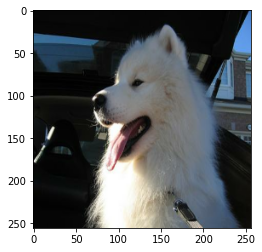

In [11]:
#Display a sample image after normalizing
for x,l in dataset.take(1):
  plt.imshow(preprocess_image_orginal(x,l)*0.5 + 0.5)


In [12]:
# Adjust hue, saturation, value of an RGB image randomly in YIQ color space.
def image__hsv_in_yiq(image):
  delta = 0.5
  lower_saturation = 0.1
  upper_saturation = 0.9
  lower_value = 0.2
  upper_value = 0.8
  image= tfa.image.random_hsv_in_yiq(image, delta, lower_saturation, upper_saturation, lower_value, upper_value)
  return image

In [14]:
# Rotate the image by a random angle between pi/16 and pi/64
def gen_rotate(image):
  image = tfa.image.rotate(image, tf.constant(np.pi/ random.randrange(16,64)))
  return image

In [15]:
# Displace the pixels in the image
def gen_transform(image):
  n = 0.1
  rand = np.random.rand(6)*n-n/2
  image = tfa.image.transform(image, [1.0 + rand[0], 0.0 + rand[1], 0.0 + rand[2], 0.0 + rand[3], 1.0 + rand[4], 0.0 + rand[5], 0.0, 0.0])
  return image

In [16]:
# Apply a 5X5 median filter
def gen_median_filter2d(image):
  image = tfa.image.median_filter2d(image, filter_shape=5)
  return image

In [17]:
# Apply a 5X5 mean filter
def gen_mean_filter2d(image):
  image = tfa.image.mean_filter2d(image, filter_shape=5)
  return image

In [18]:
# Generate edited image by applying few of the above defined tranforms with certain probablilty 
def generate_edit(image,label):
  image = normalize(image)
  if(random.random()<0.9):
    image = gen_rotate(image)
  if(random.random()<0.9):
    image = gen_transform(image)
  if(random.random()<0.6):
    image = image__hsv_in_yiq(image)
  if(random.random()<0.6):
    rn = random.random();
    if(rn<0.5):
      image = gen_median_filter2d(image)
    elif(rn<1):
      image = gen_mean_filter2d(image)
  return image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


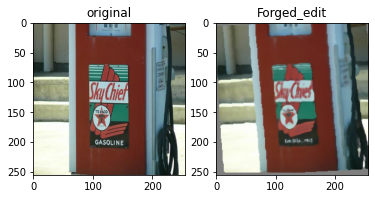

In [19]:
# Display a pair of original and edited/'forged' image
for x,l in dataset.take(5):  
  plt.subplot(121)
  plt.title('original')
  plt.imshow(preprocess_image_orginal(x,l) * 0.5 + 0.5)

  plt.subplot(122)
  plt.title('Forged_edit')
  plt.imshow(generate_edit(x,l) * 0.5 + 0.5)

In [20]:
# Create test and training data according to their labels
original = dataset.map(
    preprocess_image_orginal, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

Forged_detectable  = dataset.map(
    generate_edit, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)    

test_original= dataset_val.map(
    preprocess_image_orginal, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_Forged_detectable = dataset_val.map(
    generate_edit, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1) 

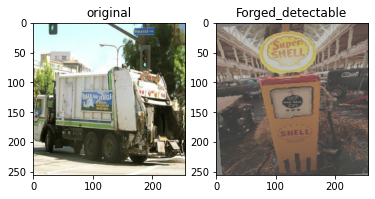

In [21]:
# Display one images from each dataset using iter
sample_original = next(iter(original))
sample_Forged_detectable = next(iter(Forged_detectable))

plt.subplot(121)
plt.title('original')
plt.imshow(sample_original[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Forged_detectable')
plt.imshow(sample_Forged_detectable[0] * 0.5 + 0.5)

# **Create Model**

In [22]:
# A convolutional downsampling layer
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [24]:
#Define the forgery detector
 
def discriminator(norm_type='batchnorm'):
  down_stack = [
      downsample(32, 4, norm_type, apply_norm=False),  
      tf.keras.layers.MaxPooling2D(), 
      downsample(32, 4, norm_type),  
      tf.keras.layers.MaxPooling2D(), 
      downsample(32, 4, norm_type),  
      downsample(32, 4, norm_type), 
      downsample(32, 4, norm_type),
      downsample(64, 4, norm_type),  
      tf.keras.layers.Dense(64),
      tf.keras.layers.Dense(1,activation='sigmoid')

  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, 3])
  x = inputs

  for down in down_stack:
    x = down(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# **Train Only Discrimnator**

In [25]:
discriminator_is_forged = discriminator(norm_type='batchnorm')

In [27]:
discriminator_is_forged.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 32)      1536      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 32)        16512     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 32)          16512 

In [28]:

loss_obj = tf.keras.losses.MeanAbsoluteError()

In [29]:
def discriminator_loss_single(predict, actual):

  if(actual == 1):
    return loss_obj(tf.ones_like(predict), predict)
  elif(actual == 0):
    return loss_obj(tf.zeros_like(predict), predict)

In [30]:
discriminator_is_forged_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
def dis_onlyTrain_step(original, forged):
  with tf.GradientTape(persistent=True) as tape:
    predict_0 = discriminator_is_forged(original)
    predict_1 = discriminator_is_forged(forged)


    disc_is_forged_loss = discriminator_loss_single(predict_1, 1 ) + discriminator_loss_single(predict_0, 0 ) 


  discriminator_is_forged_gradients = tape.gradient( disc_is_forged_loss , discriminator_is_forged.trainable_variables)

  discriminator_is_forged_optimizer.apply_gradients(zip(discriminator_is_forged_gradients,
                                                discriminator_is_forged.trainable_variables))
  
  
  return (disc_is_forged_loss)

In [32]:
EPOCHS_d = 4

In [33]:
for epoch in range(EPOCHS_d):
  start = time.time()
  print("Batch : ")

  n = 0
  ep_loss = 0
  for image_x, image_y in tf.data.Dataset.zip((original, Forged_detectable)).take(201):
    ep_loss = ep_loss + dis_onlyTrain_step(image_x, image_y)
    if n % 50 == 0:
      print ( str(n)+ " ", end='')
    n+=1
  
  if (True):
    ep_loss = ep_loss/n
    print ('\nTime taken for epoch {} is {} sec. Loss : {} \n'.format(epoch + 1,
                                                      time.time()-start, ep_loss))

Batch : 
0 50 100 150 200 
Time taken for epoch 1 is 82.14784598350525 sec. Loss : 0.5104631781578064 

Batch : 
0 50 100 150 200 
Time taken for epoch 2 is 41.07868432998657 sec. Loss : 0.2546216547489166 

Batch : 
0 50 100 150 200 
Time taken for epoch 3 is 41.07045245170593 sec. Loss : 0.26329565048217773 

Batch : 
0 50 100 150 200 
Time taken for epoch 4 is 41.05954670906067 sec. Loss : 0.23367875814437866 



In [34]:
def discriminator_accuracy(model,image_set, result):
  
  correct = 1 
  total = 1
  for image in image_set.take(100):
    predict = model(image)
    if(result == 0):
      if(predict.numpy() < 0.5):
        correct += 1
    if(result == 1):
      if(predict.numpy() > 0.5):
        correct += 1
    total = total +1

  return (correct/total*100)
   

In [36]:
acc = ( discriminator_accuracy(discriminator_is_forged,test_original ,0)+ discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,1) )/2
print(str(acc)+" %")

90.5940594059406 %


# **FGSM**

In [37]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(pretrained_model,input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    if(input_label == 1):
      in_label = tf.ones_like(prediction)
    else:
      in_label = tf.ones_like(prediction)/10000
    loss = loss_object( prediction,in_label)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [38]:
def generate_adversarial_pattern(pretrained_model,input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(prediction,input_label)
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [39]:
def display_images(pretrained_model,image):
  is_forged = pretrained_model(image)
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('IS Forged: : {} % Confidence'.format(is_forged*100))
  plt.show()


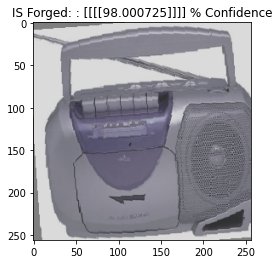

In [53]:
sample_Forged_detectable = next(iter(Forged_detectable))
image = tf.expand_dims(sample_Forged_detectable[0],axis=0)
display_images(discriminator_is_forged,image)

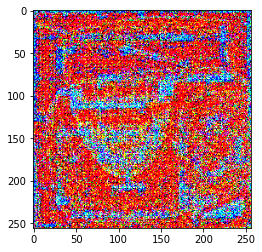

In [54]:

image = tf.expand_dims(sample_Forged_detectable[0],axis=0)
label = 1
perturbations = create_adversarial_pattern(discriminator_is_forged,image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

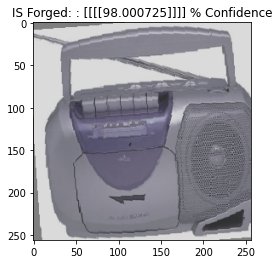

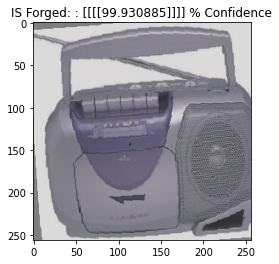

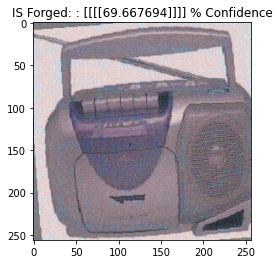

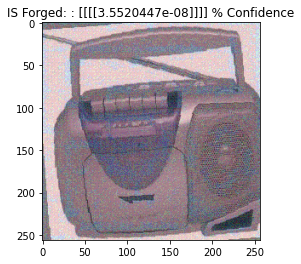

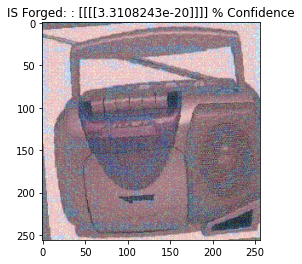

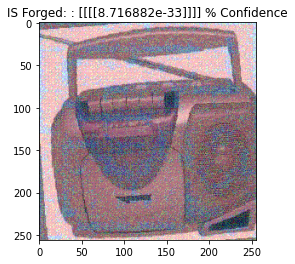

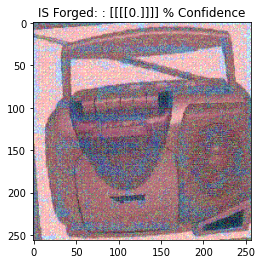

In [55]:
epsilons = [0, 0.01, 0.1, 0.15,0.20,0.25,0.30]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(discriminator_is_forged,adv_x)

# **One-step target class methods**


In [43]:
#https://arxiv.org/pdf/1611.01236.pdf

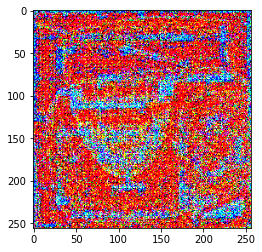

In [56]:
#sample_Forged_detectable = next(iter(Forged_detectable))

image = tf.expand_dims(sample_Forged_detectable[0],axis=0)
label = 0
perturbations = create_adversarial_pattern(discriminator_is_forged,image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

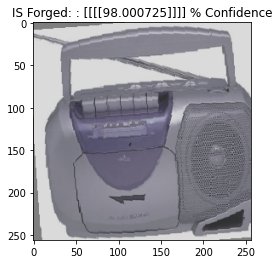

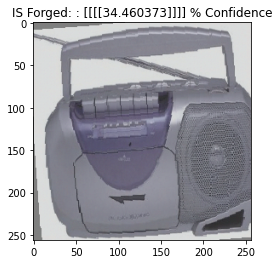

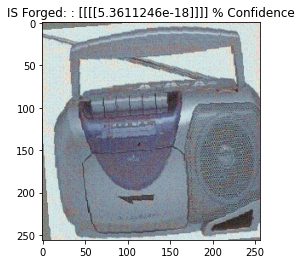

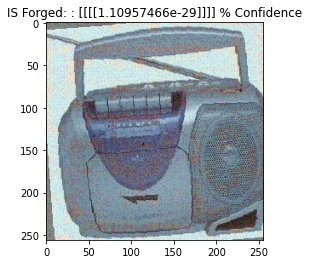

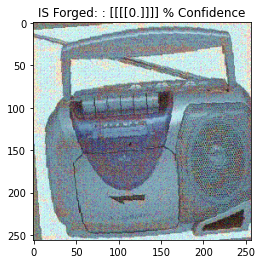

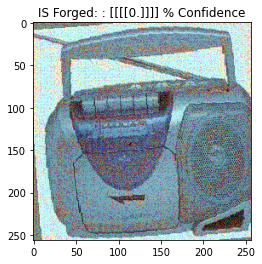

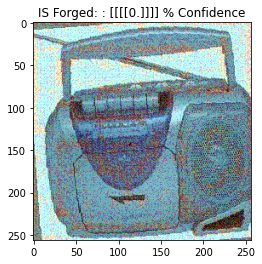

In [57]:
epsilons = [0, 0.01, 0.1, 0.15,0.20,0.25,0.30]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image - eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(discriminator_is_forged,adv_x)

# **I-FGSM**

In [58]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def iterative_FGSM(pretrained_model,input_image, input_label,eps,ite):
  for i in range(ite):
    display_images(discriminator_is_forged,input_image)
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = pretrained_model(input_image)
      if(input_label == 1):
        in_label = tf.ones_like(prediction)
      else:
        in_label = tf.ones_like(prediction)/1000
      loss = loss_object( prediction,in_label)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    input_image = input_image - eps*signed_grad
    input_image = tf.clip_by_value(input_image, -1, 1) 
    
  return input_image

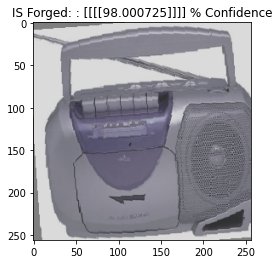

In [59]:
#sample_Forged_detectable = next(iter(Forged_detectable))

image = tf.expand_dims(sample_Forged_detectable[0],axis=0)
label = 0
display_images(discriminator_is_forged,image)

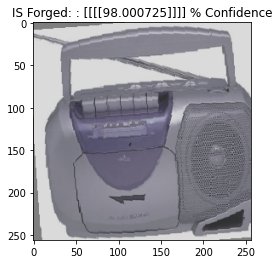

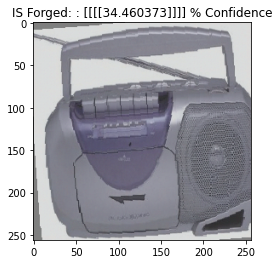

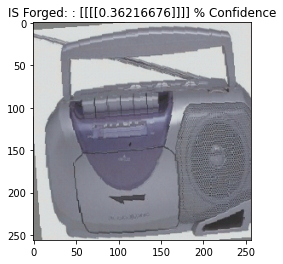

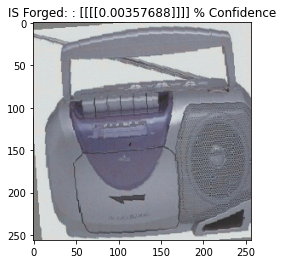

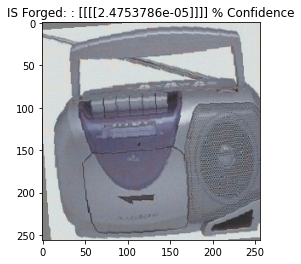

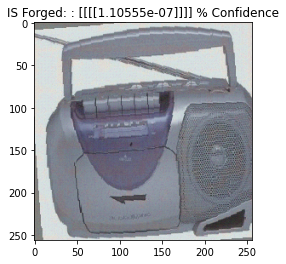

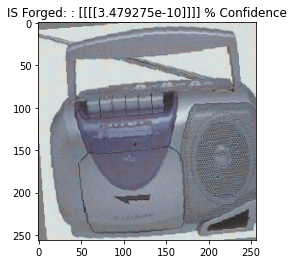

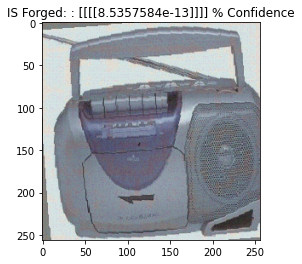

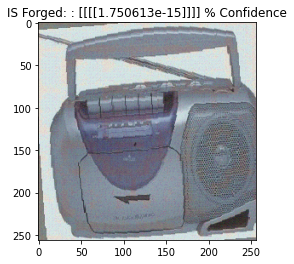

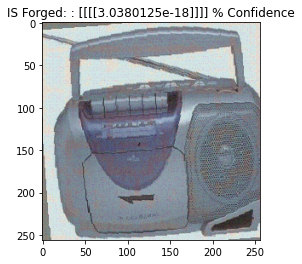

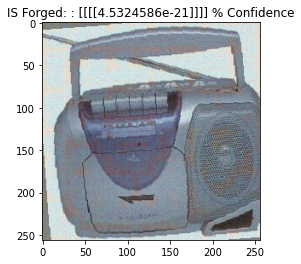

In [60]:
adv_x = iterative_FGSM(discriminator_is_forged,image, label,0.01,10)
display_images(discriminator_is_forged,adv_x)

# **Adveserial Training**

In [61]:
discriminator_is_forged.save_weights("./discriminator_is_forged_before_adverserial" )

In [62]:
EPOCHS_d = 2
for epoch in range(EPOCHS_d):
  start = time.time()
  print("Batch : ")

  n = 0
  ep_loss = 0
  for image_x, image_y in tf.data.Dataset.zip((original, Forged_detectable)).take(201):

    perturbations = create_adversarial_pattern(discriminator_is_forged,image_y, 1)
    eps = 0.05
    adv_y = image + eps*perturbations

    ep_loss = ep_loss + dis_onlyTrain_step(image_x, adv_y)
    if n % 50 == 0:
      print ( str(n)+ " ", end='')
    n+=1
  

  if (True):
    ep_loss = ep_loss/n
    #discriminator_is_forged.save_weights("/content/gdrive/My Drive/DeepForge/discriminator_is_forged_checkpoint" )
    print ('\nTime taken for epoch {} is {} sec. Loss : {} \n'.format(epoch + 1,
                                                      time.time()-start, ep_loss))

Batch : 
0 50 100 150 200 
Time taken for epoch 1 is 82.05204248428345 sec. Loss : 0.025065120309591293 

Batch : 
0 50 100 150 200 
Time taken for epoch 2 is 82.04128694534302 sec. Loss : 2.085492633341346e-05 



In [63]:
acc = ( discriminator_accuracy(discriminator_is_forged,test_original ,0)+ discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,1) )/2
print(f"Accuracy after Adveserial training {acc} %")

Accuracy after Adveserial training 85.64356435643563 %


In [64]:
discriminator_is_forged.save_weights("./discriminator_is_forged_after_adverserial")

In [65]:
discriminator_is_forged.load_weights("./discriminator_is_forged_before_adverserial")

In [66]:
acc = ( discriminator_accuracy(discriminator_is_forged,test_original ,0)+ discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,1) )/2
print(f"Accuracy before Adveserial training {acc} %")

Accuracy before Adveserial training 89.60396039603961 %
